# Mike's Sandbox, but clean(er)

## Imports

In [1]:
from astropy.io import fits
from astropy import table
from astroquery.sdss import SDSS
from astropy import coordinates as coords
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mechanize
from io import BytesIO
from astropy.table import Table
from astropy.table import vstack
from astropy.io import ascii
import matplotlib as mpl
plt.style.use(['dark_background'])
mpl.rcParams['axes.facecolor'] = (0,0,0,1)
# %matplotlib inline

/Users/mike/anaconda3/lib/python3.7/site-packages/astroquery/sdss/__init__.py:29: UserWarning: Experimental: SDSS has not yet been refactored to have its API match the rest of astroquery (but it's nearly there).
  warnings.warn("Experimental: SDSS has not yet been refactored to have its API "


In [2]:
mpl.style.use('dark_background')
mpl.rcParams['figure.facecolor'] = 'k'

Importing Melanie's catalog:

In [3]:
catFile = '../catalogs/clumpy_stripe82_fullsample.fits'
catFits = fits.open(catFile) 
catTable = table.Table(catFits[1].data)

In [4]:
len(catTable)

281

## Spectra Generation

Spectra Plotter:

In [5]:
def specPlt(catTable,index,spData):
    plt.figure(figsize=(10,5))
    plt.plot(10**spData['loglam'],spData['flux'])
    plt.title('OBJ: %s, RA: %.3f, DEC: %.3f'%(index,catTable[index]['RA'],catTable[index]['DEC']))
    plt.xlabel("Wavelength [Angstroms]")
    plt.ylabel("Flux [$10^{-17}$ erg/cm$^2$/s/A]")
    plt.tight_layout()
    plt.savefig('../spectra imgs/obj_%s.png'%index)
    plt.show()

Generating spectra from `astroquery`, using the RA/DEC:

In [6]:
def genSpectra(catTable,index,pltShow):
    pos = coords.SkyCoord(catTable[index]['RA'],
                          catTable[index]['DEC'],unit='deg')
    xid = SDSS.query_region(pos,spectro=True)
    
    if not xid:
        print('--------\nNo spectra for object %s\n--------'%index)
        return
    sp = SDSS.get_spectra(matches=xid)
    spData = sp[0][1].data
    if pltShow:
        specPlt(catTable,index,spData)
    return xid,table.Table(spData)

Here's an example from object 34:

/Users/mike/anaconda3/lib/python3.7/site-packages/astroquery/sdss/core.py:856: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  comments='#'))


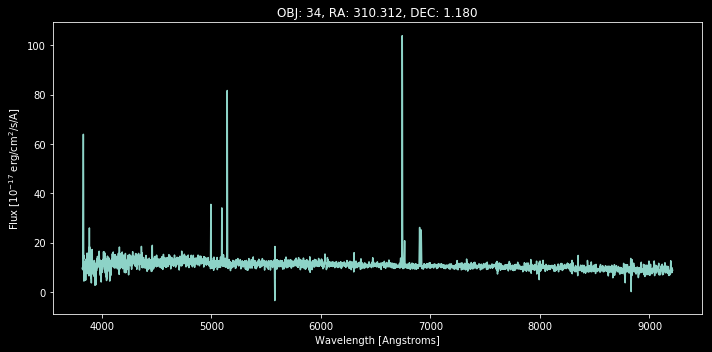

In [7]:
obj34 = genSpectra(catTable,34,True)

In [8]:
pos = coords.SkyCoord(catTable[34]['RA'],
                          catTable[34]['DEC'],unit='deg')
xid = SDSS.query_region(pos,spectro=True)
im = SDSS.get_images(matches=xid,band='g')

Here's an example with identified lines:

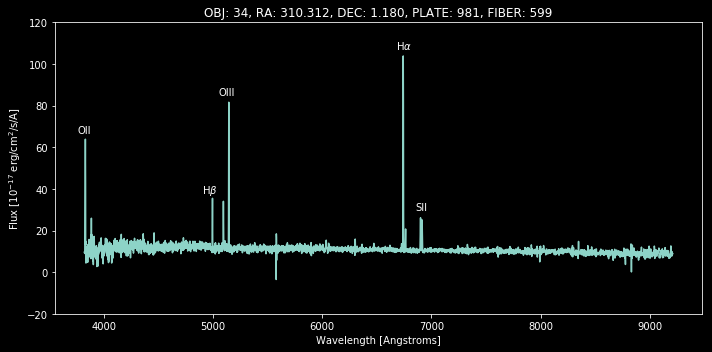

In [9]:
plt.figure(figsize=(10,5))
plt.plot(10**obj34[1]['loglam'],obj34[1]['flux'])
plt.title('OBJ: %s, RA: %.3f, DEC: %.3f, PLATE: %s, FIBER: %s'
          %(34,catTable[34]['RA'],catTable[34]['DEC'],obj34[0]['plate'][0],obj34[0]['fiberID'][0]))
plt.xlabel("Wavelength [Angstroms]")
plt.ylabel("Flux [$10^{-17}$ erg/cm$^2$/s/A]")
plt.ylim(-20,120)
# plt.xlim(6800,7000)
plt.text(6680,107,r'H$\alpha$')
plt.text(6850,30,'SII')
plt.text(5050,85,'OIII')
plt.text(4900,38,r'H$\beta$')
plt.text(3760,67,'OII')
plt.tight_layout()
plt.savefig('../spectra imgs/label_obj_%s.png'%34)
plt.show()

## Generating Metallicities

Let's use the M91 calibration mentioned in [Kewley & Ellison 2008 (KE08)](http://adsabs.harvard.edu/abs/2008ApJ...681.1183K):

$$12 + \log(O/H)_\text{lower} = 12 - 4.944 + 0.767x + 0.602x^2 - y(0.29+0.332x - 0.331x^2)$$

$$12 + \log(O/H)_\text{upper} = 12 - 2.939 - 0.2x - 0.37x^2 - 0.305 x^3 - 0.0283x^4 - y(0.0047 - 0.221x - 0.102x^2 - 0.0817x^3 - 0.00717x^4)$$

where $$x = \log R_{23} = \log\left[\frac{[\text{OII}\lambda3727 + [\text{OIII}]\lambda4959 + [\text{OIII}]\lambda5007}{\text{H}\beta}\right]$$
and $$y = \log\text{O}_{32} = \log\left[\frac{[\text{OIII}]\lambda4959 + [\text{OIII}]\lambda5007}{[\text{OII}]\lambda3727}\right]$$

In [10]:
def getlogR23(OII3727,OIII4959,OIII5007,HB):
    return np.log10((OII3727 + OIII4959 + OIII5007)/HB)

def getlogO32(OIII4959,OIII5007,OII3727):
    return np.log10((OIII4959 + OIII5007)/OII3727)

def getlogOHlow(x,y):
    return (-4.944 + 0.767*x + 0.602*x**2 - y*(0.29 + 0.332*x - 0.331*x**2))

def getlogOHup(x,y):
    return (-2.939 - 0.2*x - 0.37*x**2 - 0.305*x**3 - 0.0283*x**4 - 
            y*(0.0047 - 0.221*x - 0.102*x**2 - 0.0817*x**3 - 0.00717*x**4))

### M91 Branches

We need to determine if we are using the upper branch or the lower branch. To do this, we need to get $$\log\left(\frac{[\text{NII}]\lambda6584}{[\text{OII}]\lambda3727}\right)$$

In [11]:
def getlogNiiOii(NII6584,OII3727):
    return np.log10(NII6584/OII3727)

If this value is greater than $-1.2$, then we use the upper branch, while if it is smaller, we use the lower branch.

In [12]:
def M91cal(obj):
    
    x = getlogR23(obj['OII3726'],obj['OIII4959'],obj['OIII5007'],obj['HBeta'])
    y = getlogO32(obj['OIII4959'],obj['OIII5007'],obj['OII3726'])
    
    branchCheck = getlogNiiOii(obj['NII6584'],obj['OII3726'])
    
    if branchCheck > -1.2:
        return branchCheck, getlogOHup(x,y)
    else:
        return branchCheck, getlogOHlow(x,y)
    

## Getting Data from SDSS

SQL Tutorial: http://skyserver.sdss.org/DR15/en/help/howto/search/searchhowtohome.aspx

Another link: http://balbuceosastropy.blogspot.com/2013/10/an-easy-way-to-make-sql-queries-from.html

In [13]:
def SDSS_select(sql):
    
    '''
    input: SQL query
    output: pandas DF
    '''
    
    url = 'http://skyserver.sdss.org/dr15/en/tools/search/sql.aspx'
    br = mechanize.Browser()
    br.open(url)
    br.select_form(name='sql')
    br['cmd'] = sql
    br['format'] = ['csv']
    response = br.submit()
    file_like = BytesIO(response.get_data())
    df = pd.read_csv(file_like,skiprows=1)
    return df

In [14]:
def getSpecData(catTable,index):
    pos = coords.SkyCoord(catTable[index]['RA'],catTable[index]['DEC'],unit='deg')
    xid = SDSS.query_region(pos,spectro = True)
    
    if not xid:
#         print('--------\nNo spectra for object %s\n--------'%index)
        return False, False
    
    sp = SDSS.get_spectra(matches=xid)
    spData = sp[0][1].data
    return xid, table.Table(spData)

In [15]:
def genSQLsearch(xid):
    SQL = "SELECT \
    s.specObjID, g.class, g.subClass, x.z, x.ra, x.dec, x.plate, x.fiberID, x.MJD, \
    s.oii_3726_flux as OII3726, s.oiii_4959_flux as OIII4959,s.oiii_5007_flux as OIII5007, \
    s.h_beta_flux as HBeta,s.h_alpha_flux as HAlpha,s.nii_6584_flux as NII6584,x.logMass as logM \
    FROM galSpecLine s \
    JOIN stellarMassFSPSGranEarlyNoDust x ON x.specObjID = s.specObjID \
    JOIN specObj g ON g.specObjID = s.specObjID \
    WHERE x.plate = %s AND x.fiberID = %s"%(xid['plate'][0],xid['fiberID'][0])
    return SQL

In [16]:
def getOneSDSS(catTable,index):
    xid, spectra = getSpecData(catTable,index)
    if not xid:
        return False
    SQLsearch = genSQLsearch(xid)
    SDSS = SDSS_select(SQLsearch)
    return SDSS

In [17]:
def getCatSDSS(catTable):
    from tqdm import tqdm_notebook as tqdm
    from astropy.table import Table
    
    objBar = tqdm(desc = 'Getting Obj',total = len(catTable))
    n = 0
    nospec = 0
    while n >= 0:
#         print(n)
        if type(getOneSDSS(catTable,n)) is bool:
            objBar.update(1)
            nospec += 1
            n+=1
        else:
            SDSSTable = getOneSDSS(catTable,n)
            objBar.update(1)
            break
            
    nrange = range(n+1,len(catTable))
    for obj in nrange:
#         print('\n',obj)
        objTable = getOneSDSS(catTable,obj)
#         print(objTable)
        if type(objTable) is bool:
            objBar.update(1)
            nospec += 1
            continue
        else:
            SDSSTable = SDSSTable.append(objTable,ignore_index=True)
            objBar.update(1)
            
    SDSSTable.to_csv('../mikesandboximgs/catalog.csv',index=False)
    aTable = Table.from_pandas(SDSSTable)
#     aTable['Type_n'] = typeDic[aTable['type']]
    
    aTable.write('../mikesandboximgs/catalog.ecsv', format='ascii.ecsv', serialize_method='data_mask')  
    
    print('Number of spectra:\t',len(catTable)-nospec)
    print('Number with no spectra:\t',nospec)
    return aTable
    

Let's get the whole catalog from SDSS:

In [18]:
# catSDSS = getCatSDSS(catTable)

Importing catalog:

In [19]:
# this is early dust
catSDSS = Table.from_pandas(pd.read_csv('../mikesandboximgs/catalog.csv',index_col = False))

In [20]:
catSDSSEarlyD = Table.from_pandas(pd.read_csv('../mikesandboximgs/catalog-FSPSEarlyD.csv',index_col = False))
catSDSSEarlyN = Table.from_pandas(pd.read_csv('../mikesandboximgs/catalog-FSPSEarlyN.csv',index_col = False))
catSDSSWideD = Table.from_pandas(pd.read_csv('../mikesandboximgs/catalog-FSPSWideD.csv',index_col = False))
catSDSSWideN = Table.from_pandas(pd.read_csv('../mikesandboximgs/catalog-FSPSWideN.csv',index_col = False))

In [21]:
print('Early Dust \t\t Early No Dust \t\t Wide Dust \t\t Wide No Dust ')
for n in range(0,20):
    print(catSDSSEarlyD[n]['logM'],'\t',catSDSSEarlyN[n]['logM'],'\t',catSDSSWideD[n]['logM'],'\t',catSDSSWideN[n]['logM'],'\t')

Early Dust 		 Early No Dust 		 Wide Dust 		 Wide No Dust 
10.039219930207803 	 10.039219930207803 	 9.63960525855731 	 9.62670769229036 	
11.513085126453301 	 11.513085126453301 	 11.356552811157599 	 11.361341225680697 	
10.0522017709479 	 9.80842756327398 	 10.0522017709479 	 9.80842756327398 	
11.0510632987819 	 11.116169346537196 	 11.037073977985802 	 11.116169346537196 	
10.070017488963302 	 10.070017488963302 	 9.6809875213118 	 9.6809875213118 	
11.322639788478199 	 11.3058417453445 	 11.322639788478199 	 11.3058417453445 	
9.811521031712509 	 9.811521031712509 	 9.59476045156822 	 9.672177665318099 	
9.80370657856509 	 9.80370657856509 	 9.346360661467507 	 9.346360661467507 	
9.76424917347831 	 9.76424917347831 	 9.40634241450202 	 9.40634241450202 	
11.4977887107129 	 11.4977887107129 	 11.4977887107129 	 11.4977887107129 	
7.17008324091467 	 7.17008324091467 	 6.7044696008730496 	 6.7044696008730496 	
11.6996046936796 	 11.666423345841599 	 11.486650973036499 	 11.513972193

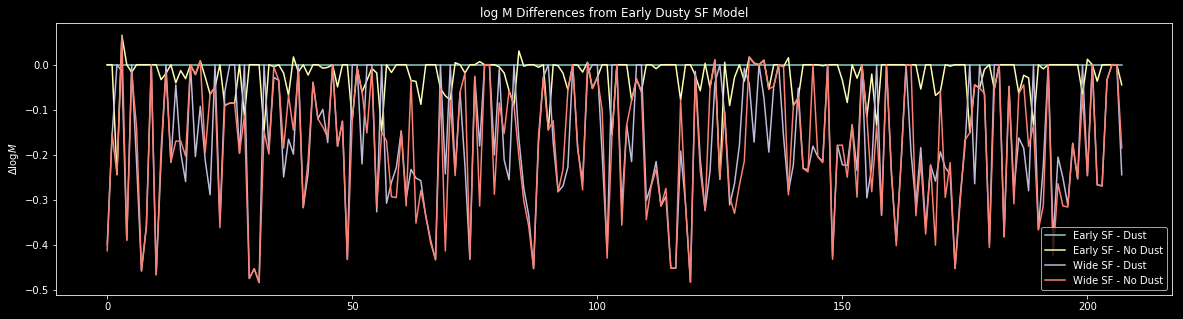

In [22]:
plt.figure(figsize=(20,5))
plt.plot(catSDSSEarlyD['logM']-catSDSSEarlyD['logM'],label='Early SF - Dust')
plt.plot(catSDSSEarlyN['logM']-catSDSSEarlyD['logM'],label='Early SF - No Dust')
plt.plot(catSDSSWideD['logM']-catSDSSEarlyD['logM'],label='Wide SF - Dust')
plt.plot(catSDSSWideN['logM']-catSDSSEarlyD['logM'],label='Wide SF - No Dust')

plt.title('log M Differences from Early Dusty SF Model')
plt.ylabel(r'$\Delta\log M$')

plt.legend()
plt.show()

In [23]:
# catSDSS.show_in_notebook()

## Generating BPT Diagram

[Kewley et al. 2013](https://arxiv.org/pdf/1307.0514.pdf) gives our classification line as:
$$ \log([\text{OIII}/\text{H}\alpha]) = \frac{0.61}{(\log([\text{NII}/\text{H}\alpha]) - 0.02} + 1.2$$
where we took $z \approx 0$ as we are in a low redshift regime. Above this line should be AGNs and other non-regular star forming galaxies (or possibly clumps?).

In [24]:
catSDSS['6584/6563'] = catSDSS['NII6584']/catSDSS['HAlpha']
catSDSS['5007/4861'] = catSDSS['OIII5007']/catSDSS['HBeta']

In [25]:
def logclassLine(x):
    return 0.61/(np.log10(x) - 0.02) + 1.2

In [26]:
def classSplit(cat):
    cat['subClass'].fill_value = '--'
    galCat = cat.filled()[cat.filled()['subClass'] == '--']
    sbCat = cat[cat['subClass'] == 'STARBURST']
    sfCat = cat[cat['subClass'] == 'STARFORMING']
    blCat = cat[cat['subClass'] == 'BROADLINE']
    agnCat = cat[cat['subClass'] == 'AGN BROADLINE']
    return galCat, sbCat, sfCat, blCat, agnCat

In [27]:
splitCat = classSplit(catSDSS)
galCat = splitCat[0]
sbCat = splitCat[1]
sfCat = splitCat[2]
blCat = splitCat[3]
agnCat = splitCat[4]

In [28]:
np.ma.is_masked(catSDSS[1]['subClass'])

True

/Users/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


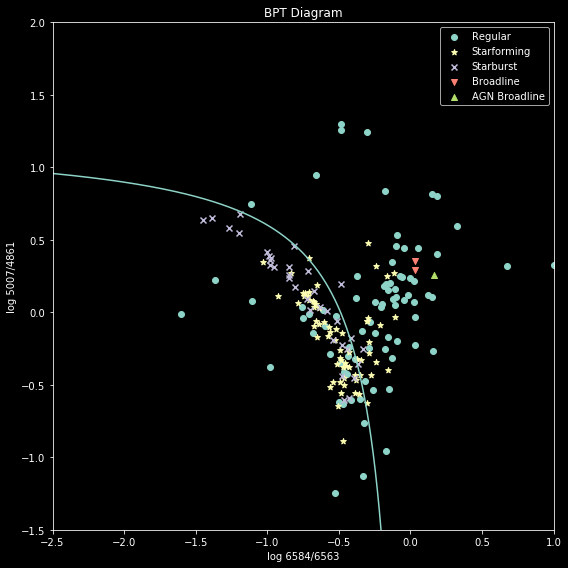

In [29]:
plt.figure(figsize=(8,8))
# plt.scatter(np.log10(catSDSS['6584/6563']),np.log10(catSDSS['5007/4861']),marker='.')
plt.scatter(np.log10(galCat['6584/6563']),np.log10(galCat['5007/4861']),marker='o',label='Regular')
plt.scatter(np.log10(sfCat['6584/6563']),np.log10(sfCat['5007/4861']),marker='*',label='Starforming')
plt.scatter(np.log10(sbCat['6584/6563']),np.log10(sbCat['5007/4861']),marker='x',label='Starburst')
plt.scatter(np.log10(blCat['6584/6563']),np.log10(blCat['5007/4861']),marker='v',label='Broadline')
plt.scatter(np.log10(agnCat['6584/6563']),np.log10(agnCat['5007/4861']),marker='^',c='C6',label='AGN Broadline')

niihaspace = np.logspace(-2.5,0,1000)
plt.plot(np.log10(niihaspace),logclassLine(niihaspace))

plt.title('BPT Diagram')
plt.xlabel('log 6584/6563')
plt.ylabel('log 5007/4861')
plt.xlim(-2.5,1)
plt.ylim(-1.5,2)
plt.legend()
plt.tight_layout()
plt.savefig('../mikesandboximgs/BPTDiagram.png')
plt.show()

Okay, so this is telling us that even the ones that SDSS classify as "galaxies" are popping way above the SF line.

## M91 Calibration

### BPT Cut
The next test we want to make is by classifying them based on this line, and seeing what happens to the M91 calibration chart of $\log[O/H] + 12$:

In [30]:
catSDSS2 = catSDSS[(np.log10(catSDSS['5007/4861']) < logclassLine(catSDSS['6584/6563'])) 
                 & (np.log10(catSDSS['6584/6563']) < 0)
                 & (catSDSS['OII3726'] > 0)
                 & (catSDSS['NII6584'] > 0)
                 & (catSDSS['OIII4959'] > 0)]

/Users/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """
/Users/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


In [31]:
splitCat2 = classSplit(catSDSS2)
galCat2 = splitCat2[0]
sbCat2 = splitCat2[1]
sfCat2 = splitCat2[2]
blCat2 = splitCat2[3]
agnCat2 = splitCat2[4]

In [32]:
print("Below SF Line:\t",len(catSDSS2),"\nFraction Left:\t",len(catSDSS2)/len(catSDSS))

Below SF Line:	 75 
Fraction Left:	 0.3605769230769231


Quickly confirming:

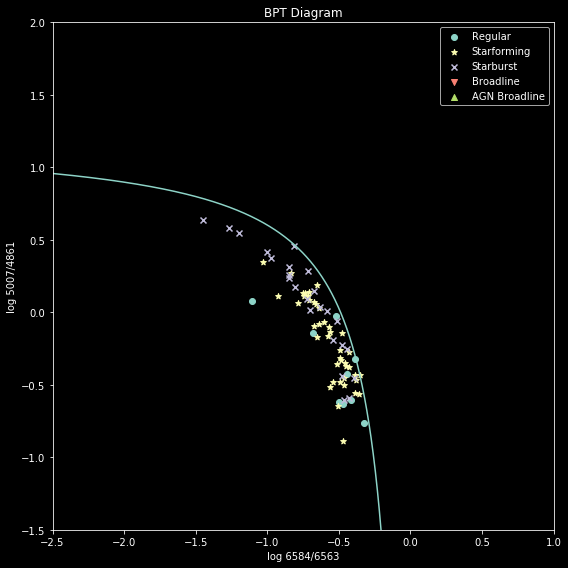

In [33]:
plt.figure(figsize=(8,8))
# catSDSS2markerList = markerMap(catSDSS2['subClass'])
# plt.scatter(np.log10(galCat2['6584/6563']),np.log10(galCat2['5007/4861']),marker='.')
plt.scatter(np.log10(galCat2['6584/6563']),np.log10(galCat2['5007/4861']),marker='o',label='Regular')
plt.scatter(np.log10(sfCat2['6584/6563']),np.log10(sfCat2['5007/4861']),marker='*',label='Starforming')
plt.scatter(np.log10(sbCat2['6584/6563']),np.log10(sbCat2['5007/4861']),marker='x',label='Starburst')
plt.scatter(np.log10(blCat2['6584/6563']),np.log10(blCat2['5007/4861']),marker='v',label='Broadline')
plt.scatter(np.log10(agnCat2['6584/6563']),np.log10(agnCat2['5007/4861']),marker='^',c='C6',label='AGN Broadline')

niihaspace = np.logspace(-2.5,0,1000)
plt.plot(np.log10(niihaspace),logclassLine(niihaspace))

plt.title('BPT Diagram')
plt.xlabel('log 6584/6563')
plt.ylabel('log 5007/4861')
plt.xlim(-2.5,1)
plt.ylim(-1.5,2)
plt.legend()
plt.tight_layout()
plt.savefig('../mikesandboximgs/BPTDiagram2.png')
plt.show()

### Generating Plot

In [34]:
M91list = [M91cal(gal)[1] + 12 for gal in catSDSS2]
logNiiOiiList = [M91cal(gal)[0] for gal in catSDSS2]
catSDSS2['M91'] = M91list
catSDSS2['logNiiOii'] = logNiiOiiList
lowBranch = catSDSS2[catSDSS2['logNiiOii'] < -1.2]
upBranch = catSDSS2[catSDSS2['logNiiOii'] >= -1.2]

In [35]:
len(lowBranch)

0

In [36]:
splitCat2 = classSplit(catSDSS2)
galCat2 = splitCat2[0]
sbCat2 = splitCat2[1]
sfCat2 = splitCat2[2]
blCat2 = splitCat2[3]
agnCat2 = splitCat2[4]

The robust fit for M91 cited in KE08 is $$\log\left(\frac{O}{H}\right) + 12 = 45.5323 - 12.2469\log M + 1.32882(\log M)^2 - 0.0471074(\log M)^3$$

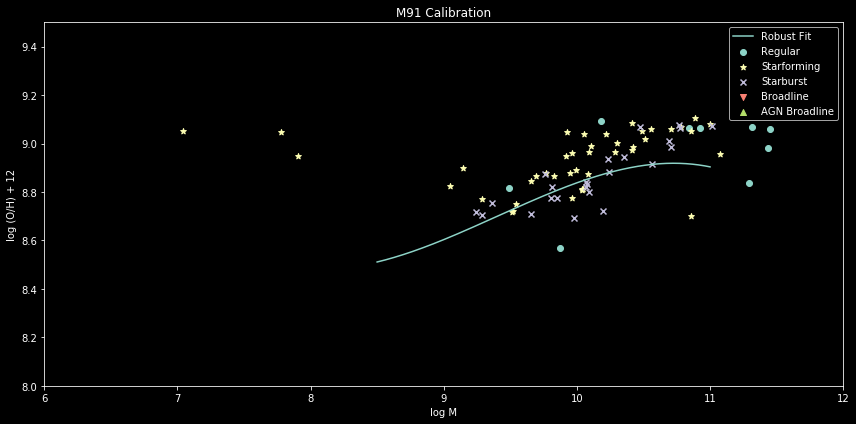

In [37]:
logMspace = np.linspace(8.5,11,1000)
def M91Fit(logM):
    return 45.5323 - 12.2469*logM +1.32882*logM**2 - 0.0471074*logM**3
    
plt.figure(figsize=(12,6))
# plt.scatter(upBranch['logM'],upBranch['M91'],marker = '.',label='upper branch')
# plt.scatter(lowBranch['logM'],lowBranch['M91'],marker = '.',label='lower branch')
plt.scatter(galCat2['logM'],galCat2['M91'],marker = 'o',label='Regular')
plt.scatter(sfCat2['logM'],sfCat2['M91'],marker = '*',label='Starforming')
plt.scatter(sbCat2['logM'],sbCat2['M91'],marker = 'x',label='Starburst')
plt.scatter(blCat2['logM'],blCat2['M91'],marker = 'v',label='Broadline')
plt.scatter(agnCat2['logM'],agnCat2['M91'],marker = '^',c='C6',label='AGN Broadline')
plt.plot(logMspace,M91Fit(logMspace),label='Robust Fit')
plt.title('M91 Calibration')
plt.xlabel('log M')
plt.ylabel('log (O/H) + 12')
plt.xlim(6,12)
plt.ylim(8,9.5)
plt.legend()
plt.tight_layout()
plt.savefig('../mikesandboximgs/m91.png')

## Investigating Lower Mass Objects

The three that are smaller mass are classified as `STARFORMING`. I will have to look into the images of the three specifically. The $\log[\text{O}/\text{H}] + 12$ measurements seem to line up reasonably with the other galaxies.

In [38]:
lowMass = catSDSS2[catSDSS2['logM'] <= 8.5]

(array([ 5., 10., 12., 12.,  8., 10., 11.,  3.,  2.,  2.]),
 array([-0.89287857, -0.68903213, -0.48518569, -0.28133925, -0.07749281,
         0.12635363,  0.33020007,  0.53404651,  0.73789295,  0.94173939,
         1.14558583]),
 <a list of 10 Patch objects>)

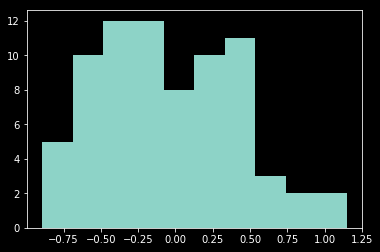

In [39]:
plt.hist(catSDSS2['logNiiOii'])

In [40]:
lowMass

specObjID,class,subClass,z,ra,dec,plate,fiberID,MJD,OII3726,OIII4959,OIII5007,HBeta,HAlpha,NII6584,logM,6584/6563,5007/4861,M91,logNiiOii
int64,str6,str13,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1661840406855313408,GALAXY,STARFORMING,0.07734468,334.1681200000001,-0.96763,1476,44,52964,26.13164,8.050787,29.79185,56.06377,301.7276,112.9446,7.77690722851942,0.3743263791578894,0.5313921985624585,9.04959965379015,0.6356988051339924
1678727256727382016,GALAXY,STARFORMING,0.03292816,4.879452,-0.60177,1491,38,52996,55.34501,9.218669,32.70643,48.17247,156.0314,34.77625,7.90438092122952,0.2228798177802673,0.6789444261421513,8.947588816527292,-0.20179572099619789
1702402778246178816,GALAXY,STARFORMING,0.02889183,44.169167,-0.248029,1512,153,53742,12.63868,3.245201,6.9761690000000005,20.96936,77.33118,22.20755,7.0448300934655,0.28717459115456406,0.3326839254989184,9.05262118532194,0.24479893054989146


### Quickly re-writing SQL Code

Really quickly, I'll need to re-write some of the SQL code to take custom RA and DEC.

In [41]:
def getSpecDataRADEC(RA,DEC):
    pos = coords.SkyCoord(RA,DEC,unit='deg')
    xid = SDSS.query_region(pos,spectro = True)
    
    if not xid:
        return False, False
    
    if len(xid) > 1:
#         print ('oh no')
        xid = Table(xid[-1])
    
    sp = SDSS.get_spectra(matches=xid)
    spData = sp[0][1].data
    return xid, table.Table(spData)

Let's make a function that still generates a $\log(O/H) + 12$ for this, even without the mass:

In [42]:
def genSQLsearchNOMASS(xid):
    SQL = "SELECT \
    s.specObjID, g.class, g.subClass, g.z, g.ra, g.dec, g.plate, g.fiberID, g.MJD, \
    s.oii_3726_flux as OII3726, s.oiii_4959_flux as OIII4959,s.oiii_5007_flux as OIII5007, \
    s.h_beta_flux as HBeta,s.h_alpha_flux as HAlpha,s.nii_6584_flux as NII6584 \
    FROM galSpecLine s \
    JOIN specObj g ON g.specObjID = s.specObjID \
    WHERE g.plate = %s AND g.fiberID = %s"%(xid['plate'][0],xid['fiberID'][0])
    return SQL

In [43]:
def getSDSSRADEC(RA,DEC):
    xid, spectra = getSpecDataRADEC(RA,DEC)
    if not xid:
        print('No xid')
        return False
    SQLsearch = genSQLsearch(xid)
    SDSS = SDSS_select(SQLsearch)
    
    if len(SDSS) < 1:
        SQLsearch = genSQLsearchNOMASS(xid)
        SDSS = SDSS_select(SQLsearch)
    
    return SDSS

In [44]:
def finishTableRADEC(RA,DEC,og):
    pdObj = getSDSSRADEC(RA,DEC)
    if type(pdObj) is bool:
        return False
    obj = Table.from_pandas(pdObj)
#     print(obj)
    obj['6584/6563'] = obj['NII6584']/obj['HAlpha']
    obj['5007/4861'] = obj['OIII5007']/obj['HBeta']
    obj['M91'] = M91cal(obj[0])[1] + 12
    obj['logNiiOii'] = M91cal(obj[0])[0]
    return vstack([og,obj])

### Function?

Sure would make my life easier.

In [45]:
def clumpLook(ra,dec,objOG):
    try:
        objb = finishTableRADEC(ra,dec,objOG)
        if type(objb) is bool:
            return
        elif np.abs((objb[0]['z']-objb[1]['z'])/objb[0]['z']) >= 0.1:
            print ('not same objects: redshifts of %.5f and %.5f'%(objb[0]['z'],objb[1]['z']))
            return
    except IndexError:
        print('No galSpecLine')
        return
#     print(objb['in','z','ra','dec','logM','M91'])
    print(distDelta(objb))
    objList.append(objb)
    return objb

### Getting Separations

[link](http://docs.astropy.org/en/stable/coordinates/matchsep.html)

`astropy.coordinates.SkyCoord.separation_3d()` + `astropy.coordinates.Distance()` to get distances

In [46]:
from astropy import units as u
from astropy.coordinates import SkyCoord, Distance

def distBetween(o1,o2):
    c1 = SkyCoord(o1['ra']*u.deg,o1['dec']*u.deg,distance=Distance(z=o1['z']))
    c2 = SkyCoord(o2['ra']*u.deg,o2['dec']*u.deg,distance=Distance(z=o2['z']))
    return c1.separation_3d(c2)

In [47]:
def distDelta(ot):
    dist = distBetween(ot[0],ot[1])
    delta = np.abs(ot[0]['M91']-ot[1]['M91'])
#     print('Dist.:',dist)
#     print('Delta:',delta)    
    return dist.value,delta

I'm just going to put this list here:

In [48]:
objList = []

### First Object

([link](http://skyserver.sdss.org/dr15/en/tools/chart/navi.aspx?ra=334.16810958956&dec=-0.96762682445652&scale=0.2))

In [49]:
lowMass[0]['specObjID','z','ra','dec','plate','MJD','fiberID','logM','M91']

specObjID,z,ra,dec,plate,MJD,fiberID,logM,M91
int64,float64,float64,float64,int64,int64,int64,float64,float64
1661840406855313408,0.07734468,334.1681200000001,-0.96763,1476,52964,44,7.77690722851942,9.04959965379015


Here is the first object `1661840406855313408`:

![](http://skyserver.sdss.org/dr15/SkyServerWS/ImgCutout/getjpeg?ra=334.16812&dec=-0.96763&scale=0.0845070422535211&width=400&height=400)![](http://skyserver.sdss.org/dr15/SkyServerWS/ImgCutout/getjpeg?ra=334.16812&dec=-0.96763&scale=0.0845070422535211&width=400&height=400&opt=SIG)

Both this object and the other object with a spectrum in this image are classified as `STARFORMING` by SDSS, and they both look off center to the actual center of the galaxy.

In [50]:
object1 = lowMass[0]

The RA and Dec of the second object is (334.168, -0.96589):

In [51]:
obj1s = clumpLook(334.168,-0.96589,object1)
obj1s['z','ra','dec','logM','M91']

/Users/mike/anaconda3/lib/python3.7/site-packages/astroquery/sdss/core.py:856: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  comments='#'))


(2.6226581478948794, 0.04013351839824786)


z,ra,dec,logM,M91
float64,float64,float64,float64,float64
0.07734468,334.1681200000001,-0.96763,7.77690722851942,9.04959965379015
0.07681248,334.1683,-0.96589253,10.885560340004,9.009466135391902


Comparing these two objects (the top being the object of interest and the bottom being the other object), we can see that they have very similar `M91` ($\log(O/H) + 12$) but very different masses. The mass of the other object is in line with most of the other galaxies in the M91 diagram, implying that it is the central part of the galaxy, while the object of interest as mentioned before is much smaller.

### Second Object

([link](http://skyserver.sdss.org/dr15/en/tools/chart/navi.aspx?ra=334.16810958956&dec=-0.96762682445652&scale=0.2))

In [52]:
lowMass[1]['specObjID','z','ra','dec','plate','MJD','fiberID','logM','M91']

specObjID,z,ra,dec,plate,MJD,fiberID,logM,M91
int64,float64,float64,float64,int64,int64,int64,float64,float64
1678727256727382016,0.03292816,4.879452,-0.60177,1491,52996,38,7.90438092122952,8.947588816527292


Here is the second object `1678727256727382016`:

![](http://skyserver.sdss.org/dr15/SkyServerWS/ImgCutout/getjpeg?ra=4.879452&dec=-0.60177&scale=0.0853343447033446&width=400&height=400)![](http://skyserver.sdss.org/dr15/SkyServerWS/ImgCutout/getjpeg?ra=4.879452&dec=-0.60177&scale=0.0853343447033446&width=400&height=400&opt=SIG)

This object is classified as `STARFORMING` while the other object to the right is classified as `STARBURST`. Both look offcenter to the center of the galaxy but it's also a weird looking one

In [53]:
object2 = lowMass[1]

In [54]:
object2

specObjID,class,subClass,z,ra,dec,plate,fiberID,MJD,OII3726,OIII4959,OIII5007,HBeta,HAlpha,NII6584,logM,6584/6563,5007/4861,M91,logNiiOii
int64,str6,str13,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1678727256727382016,GALAXY,STARFORMING,0.03292816,4.879452,-0.60177,1491,38,52996,55.34501,9.218669,32.70643,48.17247,156.0314,34.77625,7.90438092122952,0.2228798177802673,0.6789444261421513,8.947588816527292,-0.20179572099619789


The RA and Dec of the other object is (4.8778,-0.60178):

In [108]:
obj2s = clumpLook(4.8778,-0.60175,object2)
obj2s

(0.36128771386693803, 0.1159032795239483)


specObjID,class,subClass,z,ra,dec,plate,fiberID,MJD,OII3726,OIII4959,OIII5007,HBeta,HAlpha,NII6584,logM,6584/6563,5007/4861,M91,logNiiOii
int64,str6,str13,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1678727256727382016,GALAXY,STARFORMING,0.03292816,4.879452,-0.60177,1491,38,52996,55.34501,9.218669,32.70643,48.17247,156.0314,34.77625,7.90438092122952,0.2228798177802673,0.6789444261421513,8.947588816527292,-0.20179572099619789
437980866312955904,GALAXY,STARBURST,0.03285039,4.877848200000001,-0.60175283,389,21,51795,326.444,120.0465,338.3001,235.3608,655.7142,132.9357,--,0.2027342095077398,1.4373680748875768,8.831685537003343,-0.3901670639614821


This object just [doesn't have anything](http://skyserver.sdss.org/dr15/en/tools/explore/DisplayResults.aspx?name=stellarMassFSPSGranEarlyDust&id=1237657190370443316&spec=437980866312955904&apid=&fieldId=0x112d0aa841bd0000&ra=4.87783844259087&dec=-0.601759910130567&plateId=437975093876910080&mangaid=) under `stellarMassFSPSGranEarlyDust`. However we can still look at the $\log (O/H) + 12$ and see that it is fairly similar.

### Third Object

([link](http://skyserver.sdss.org/dr15/en/tools/chart/navi.aspx?ra=44.169167&dec=-0.248029&scale=0.2))

In [56]:
lowMass[2]['specObjID','z','ra','dec','plate','MJD','fiberID','logM','M91']

specObjID,z,ra,dec,plate,MJD,fiberID,logM,M91
int64,float64,float64,float64,int64,int64,int64,float64,float64
1702402778246178816,0.02889183,44.169167,-0.248029,1512,53742,153,7.0448300934655,9.05262118532194


Here is the third object, `1702402778246178816`:

![](http://skyserver.sdss.org/dr15/SkyServerWS/ImgCutout/getjpeg?ra=44.1692503341103&dec=-0.247417888888655&scale=0.0626666666666667&width=400&height=400)![](http://skyserver.sdss.org/dr15/SkyServerWS/ImgCutout/getjpeg?ra=44.1692503341103&dec=-0.247417888888655&scale=0.0626666666666667&width=400&height=400&opt=SIG)

All three of these are labeled as `STARFORMING` regions, though the upper left object is a significantly redder object than the others (that doesn't make sense...). It would appear that the top object is the center of the galaxy while the other two objects are clumpy areas.

In [57]:
object3 = lowMass[2]

In [58]:
object3

specObjID,class,subClass,z,ra,dec,plate,fiberID,MJD,OII3726,OIII4959,OIII5007,HBeta,HAlpha,NII6584,logM,6584/6563,5007/4861,M91,logNiiOii
int64,str6,str13,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1702402778246178816,GALAXY,STARFORMING,0.02889183,44.169167,-0.248029,1512,153,53742,12.63868,3.245201,6.9761690000000005,20.96936,77.33118,22.20755,7.0448300934655,0.28717459115456406,0.3326839254989184,9.05262118532194,0.24479893054989146


#### Top

Let's try the top object, with an RA and Dec of (44.1697,-0.24554):

In [59]:
obj3s = clumpLook(44.169524,-0.245584,object3)
obj3s['z','ra','dec','logM','M91']

/Users/mike/anaconda3/lib/python3.7/site-packages/astroquery/sdss/core.py:856: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  comments='#'))


(0.6858804114242607, 0.08405742628718116)


z,ra,dec,logM,M91
float64,float64,float64,float64,float64
0.02889183,44.169167,-0.248029,7.0448300934655,9.05262118532194
0.0290403,44.169523999999996,-0.24558446,10.008372867640901,8.968563759034758


Much like the first outlier, the object of interest has a much smaller mass than the purported center of the galaxy ($\log M_\text{center} \approx 10$, which fits well with the other galaxies). These also have similar $\log(O/H) + 12$, both around 9, though there is a larger difference between the two.

In [60]:
objList.append(obj3s)

#### ~~Upper Left~~

The RA and Dec of the upper left object is (44.17118,-0.24588):

In [61]:
obj3sb = clumpLook(44.17118,-0.24588,obj3s)
obj3sb

No xid


So there's no `astroquery` spectra. Lovely.

What if I manually search it? The `plate` is `7820` and the `fiberID` is `228`.

In [62]:
def genSQLsearchPFID(plate,fiberID):
    SQL = "SELECT \
    s.specObjID, g.class, g.subClass, g.z, g.ra, g.dec, g.plate, g.fiberID, g.MJD, \
    s.oii_3726_flux as OII3726, s.oiii_4959_flux as OIII4959,s.oiii_5007_flux as OIII5007, \
    s.h_beta_flux as HBeta,s.h_alpha_flux as HAlpha,s.nii_6584_flux as NII6584 \
    FROM galSpecLine s \
    JOIN specObj g ON g.specObjID = s.specObjID \
    WHERE g.plate = %s AND g.fiberID = %s"%(plate,fiberID)
    return SQL

In [63]:
object3b = SDSS_select(genSQLsearchPFID(7820,228))

In [64]:
object3b

,specObjID,class,subClass,z,ra,dec,plate,fiberID,MJD,OII3726,OIII4959,OIII5007,HBeta,HAlpha,NII6584


Great, nothing again.

Further research shows this also has [no fit parameters](http://skyserver.sdss.org/dr15/en/tools/explore/parameters.aspx?id=1237663783679885316&spec=8804600060845203456&apid=&fieldId=0x112d10a7619b0000&ra=44.1710389998575&dec=-0.24582688937338&plateId=8804537388686618624&mangaid=) AND [no spectra analysis](http://skyserver.sdss.org/dr15/en/tools/explore/DisplayResults.aspx?name=galSpecLineQuery&id=1237663783140196543&spec=8813584171278508032&apid=&fieldId=0x112d10a741700000&ra=37.8582914161963&dec=-0.793970665853889&plateId=8813544588864106496&mangaid=) which is really unhelpful. They are at the same redshift ($z \approx 0.029$) though, so they should be related somehow.

**[link](http://skyserver.sdss.org/dr15/en/tools/explore/Summary.aspx?sid=8804600060845203456)**

## Looking at other objects

It's worth looking at some of the other objects in Melanie's catalog to see which ones are actually clumps. It's worth noting that we started with a catalog of 281 objects and are now working with 75 objects, which might not necessarily match with the 104 clumpy galaxies selected in Melanie's thesis.

In [65]:
# catSDSS2['specObjID','subClass','z','ra','dec','plate','fiberID','logM','M91'].show_in_notebook()

We can look on page 109 of Melanie's thesis for objects that have multiple spectra and start from there.

In [66]:
intObjs = [(23.422,-1.158),(22.515,0.743),(4.878,-0.602),(37.884,-0.728),(37.861,-0.793),(329.604,-0.740),(10.349,-0.065),(13.241,0.369),
           (7.410,0.410),(11.389,-1.106),(35.901,0.226),(350.466,-0.691),(350.533,-0.054),(20.575,1.007),(46.347,-0.242),(323.217,-0.311),
           (41.796,-1.044),(18.415,0.875),(14.731,1.005),(23.281,0.176),(28.497,-0.750),(33.000,1.218),(57.287,1.163),(47.617,1.098),
           (43,355,-0.232),(41.489,-0.753),(357.970,0.755),(20.339,0.090),(7.948,0.559),(324.986,0.323),(2.526,-0.438),(32.201,0.800),
           (56.529,0.390),(2.915,-0.477),(34.749,-0.601),(45.264,-0.743),(312.717,-0.326),(312340.309,-0.621),(333.085,0.561),(351.096,-0.108),
           (47.492,-0.694),(49.025,-0.440),(40.200,1.105),(7.437,0.170),(350.147,-0.881),(35.624,0.383),(47.889,-1.244),(43.711,1.057),(49.334,-0.077)]

Ideally we would do all of these, but this would take a lot of time and I don't quite have that at the moment.

In [67]:
len(intObjs)

49

In [68]:
from math import isclose

iList = []
for obj in intObjs:
    n=0
    for cat in catSDSS2:
        if isclose(obj[0],cat['ra'],abs_tol = 1e-3) and isclose(obj[1],cat['dec'],abs_tol=1e-3):
            print(intObjs.index(obj),n,cat['ra'],cat['dec'])
            iList.append(n)
        n += 1

4 58 37.861032 -0.79292493
7 23 13.240837 0.36876689
12 17 350.53332 -0.053945790999999986
13 73 20.57553 1.0072288
15 5 323.21669 -0.31125654
16 33 41.796045 -1.0439105
21 46 32.999845 1.21745
29 21 324.98645 0.32325996
30 12 2.52555 -0.43833
38 50 333.08524 0.56052912
46 55 47.888664 -1.244449


We'll start with these 11 objects. 

In [69]:
intList = catSDSS2[iList]
intList['i'] = iList
intList['in'] = intList['i'].astype(str)
intList['in','specObjID','z','ra','dec','plate','fiberID','MJD','logM','M91']

in,specObjID,z,ra,dec,plate,fiberID,MJD,logM,M91
str21,int64,float64,float64,float64,int64,int64,int64,float64,float64
58,458268505532295168,0.04061754,37.861032,-0.79292493,407,99,51820,9.540666433391731,8.751602025629142
23,779250590688503808,0.03411131,13.240837,0.36876689,692,465,52201,9.97580579209424,8.690572204065635
17,431292812344977408,0.05678048,350.53332,-0.053945790999999986,383,266,51818,10.1927458010051,8.71949522053418
73,449322604000471040,0.05546235,20.57553,1.0072288,399,322,51817,10.2300016301781,8.936304372501347
5,1113576896802613248,0.0312197,323.21669,-0.31125654,989,225,52468,9.76424917347831,8.872815850377155
33,460529377172547584,0.02852489,41.796045,-1.0439105,409,132,51871,9.657531521017589,8.843536573338085
46,456089823174748160,0.02335213,32.999845,1.21745,405,365,51816,9.65258303492498,8.707090747322104
21,1114759421507954688,0.04987694,324.98645,0.32325996,990,431,52465,9.99331542697075,8.889916674145534
12,1227242492034836480,0.03161843,2.52555,-0.43833,1090,42,52903,9.04386283511927,8.826393116140753


All of these are pretty high mass, so the spectra we have *don't* have may be the clumps we are looking for.

### Object 58

Our first object will be object `58` ([link](http://skyserver.sdss.org/dr15/en/tools/chart/navi.aspx?ra=334.16810958956&dec=-0.96762682445652&scale=0.2)):

In [70]:
obj58 = intList[0]
obj58['in','specObjID','z','ra','dec','plate','MJD','fiberID','logM','M91']

in,specObjID,z,ra,dec,plate,MJD,fiberID,logM,M91
str21,int64,float64,float64,float64,int64,int64,int64,float64,float64
58,458268505532295168,0.04061754,37.861032,-0.79292493,407,51820,99,9.540666433391731,8.751602025629142


![](http://skyserver.sdss.org/dr15/SkyServerWS/ImgCutout/getjpeg?ra=37.861032&dec=-0.7929&scale=0.0853343447033446&width=400&height=400)![](http://skyserver.sdss.org/dr15/SkyServerWS/ImgCutout/getjpeg?ra=37.861032&dec=-0.7929&scale=0.0853343447033446&width=400&height=400&opt=SIG)

This looks like it might be the central object. The other two objects are at `(37.8598,-0.79303)` and `(37.85832,-0.794)`, and look like bright, blue clumps.

#### Clump 1

Looking at the first of the clumps:

In [71]:
obj58b = clumpLook(37.8598,-0.79303,obj58)
obj58b['in','z','ra','dec','plate','MJD','fiberID','logM','M91']

/Users/mike/anaconda3/lib/python3.7/site-packages/astroquery/sdss/core.py:856: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  comments='#'))


(0.6474928985936967, 0.05761335494210229)


in,z,ra,dec,plate,MJD,fiberID,logM,M91
str21,float64,float64,float64,int64,int64,int64,float64,float64
58,0.04061754,37.861032,-0.79292493,407,51820,99,9.540666433391731,8.751602025629142
--,0.04047964,37.859798,-0.792868,1071,52641,119,9.1579648524287,8.69398867068704


In [72]:
objList.append(obj58b)

Initial inspection is telling us that that the mass isn't much different, and neither are the metallicities. What does that mean?

#### ~~Clump 2 (not actually clump)~~

Let's look at the other object:

In [73]:
obj58c = clumpLook(37.85832,-0.794,obj58b)

No xid


Alrighty then... a quick look shows that there are no fit parameters (therefore no `logM`) but there is stuff in `galSpecLine`, which is nice I guess. Let's do a search based on the plate (`1476`) and fiber (`44`):

In [74]:
def finishTablePLATEFIBER(plate,fiber,og):
    pdObj = SDSS_select(genSQLsearchPFID(plate,fiber))
    if type(pdObj) is bool:
        return False
    obj = Table.from_pandas(pdObj)
#     print(obj)
    obj['6584/6563'] = obj['NII6584']/obj['HAlpha']
    obj['5007/4861'] = obj['OIII5007']/obj['HBeta']
    obj['M91'] = M91cal(obj[0])[1] + 12
    obj['logNiiOii'] = M91cal(obj[0])[0]
    return vstack([og,obj])

In [75]:
obj58c = finishTablePLATEFIBER(1476,44,obj58)
obj58c[-1]['in'] = '58c'
obj58c['in','specObjID','z','ra','dec','plate','MJD','fiberID','logM','M91']

in,specObjID,z,ra,dec,plate,MJD,fiberID,logM,M91
str21,int64,float64,float64,float64,int64,int64,int64,float64,float64
58,458268505532295168,0.04061754,37.861032,-0.79292493,407,51820,99,9.540666433391731,8.751602025629142
58c,1661840406855313408,0.07734468,334.16812000000004,-0.9676299999999999,1476,52964,44,--,9.04959965379015


Object 58c is at a much higher redshift than the other two objects, so we can safely ignore it.

### Object 23

([link](http://skyserver.sdss.org/dr15/en/tools/chart/navi.aspx?ra=13.240837&dec=0.36876689&scale=0.2)):

In [76]:
obj23 = intList[1]
obj23['in','specObjID','z','ra','dec','plate','MJD','fiberID','logM','M91']

in,specObjID,z,ra,dec,plate,MJD,fiberID,logM,M91
str21,int64,float64,float64,float64,int64,int64,int64,float64,float64
23,779250590688503808,0.03411131,13.240837,0.36876689,692,52201,465,9.97580579209424,8.690572204065635


![](http://skyserver.sdss.org/dr15/SkyServerWS/ImgCutout/getjpeg?ra=13.240837&dec=0.36876689&scale=0.0853343447033446&width=400&height=400)![](http://skyserver.sdss.org/dr15/SkyServerWS/ImgCutout/getjpeg?ra=13.240837&dec=0.36876689&scale=0.0853343447033446&width=400&height=400&opt=SIG)

Once again, it looks like we have a galactic center. The other object (at `(13.24227, 0.36867)`) is extremely blue in comparison.

In [77]:
obj23b = clumpLook(13.24227,0.36867,obj23)
obj23b['in','specObjID','z','ra','dec','plate','MJD','fiberID','logM','M91']

/Users/mike/anaconda3/lib/python3.7/site-packages/astroquery/sdss/core.py:856: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  comments='#'))


(1.0816721598622356, 0.03743134638816592)


in,specObjID,z,ra,dec,plate,MJD,fiberID,logM,M91
str21,int64,float64,float64,float64,int64,int64,int64,float64,float64
23,779250590688503808,0.03411131,13.240837,0.36876689,692,52201,465,9.97580579209424,8.690572204065635
--,1219445848656603136,0.03387882,13.242154999999999,0.368796,1083,52520,350,9.14296063976535,8.728003550453801


Once again, similar masses and similar metallicities.

### Object 17

([link](http://skyserver.sdss.org/dr15/en/tools/chart/navi.aspx?ra=13.240837&dec=0.36876689&scale=0.2)):

In [78]:
obj17 = intList[2]
obj17['in','specObjID','z','ra','dec','plate','MJD','fiberID','logM','M91']

in,specObjID,z,ra,dec,plate,MJD,fiberID,logM,M91
str21,int64,float64,float64,float64,int64,int64,int64,float64,float64
17,431292812344977408,0.05678048,350.53332,-0.053945790999999986,383,51818,266,10.1927458010051,8.71949522053418


![](http://skyserver.sdss.org/dr15/SkyServerWS/ImgCutout/getjpeg?ra=350.5333&dec=-0.0539&scale=0.0853343447033446&width=400&height=400)![](http://skyserver.sdss.org/dr15/SkyServerWS/ImgCutout/getjpeg?ra=350.5333&dec=-0.0539&scale=0.0853343447033446&width=400&height=400&opt=SIG)

This is pretty blobby, but the main object seems to once again be a central object. The other is at `(350.53406,-0.05564)`.

In [79]:
obj17b = clumpLook(350.53406,-0.05564,obj17)
obj17b['in','specObjID','z','ra','dec','plate','MJD','fiberID','logM','M91']

/Users/mike/anaconda3/lib/python3.7/site-packages/astroquery/sdss/core.py:856: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  comments='#'))


(0.7009004438266925, 0.010537196620598266)


in,specObjID,z,ra,dec,plate,MJD,fiberID,logM,M91
str21,int64,float64,float64,float64,int64,int64,int64,float64,float64
17,431292812344977408,0.05678048,350.53332,-0.053945790999999986,383,51818,266,10.1927458010051,8.71949522053418
--,1672035903771535360,0.05663445,350.53399,-0.05557,1485,52992,271,9.36869459459909,8.730032417154778


### Object 73

([link](http://skyserver.sdss.org/dr15/en/tools/chart/navi.aspx?ra=20.57553&dec=1.0072288&scale=0.2)):

In [80]:
obj73 = intList[3]
obj73['in','specObjID','z','ra','dec','plate','MJD','fiberID','logM','M91']

in,specObjID,z,ra,dec,plate,MJD,fiberID,logM,M91
str21,int64,float64,float64,float64,int64,int64,int64,float64,float64
73,449322604000471040,0.05546235,20.57553,1.0072288,399,51817,322,10.2300016301781,8.936304372501347


![](http://skyserver.sdss.org/dr15/SkyServerWS/ImgCutout/getjpeg?ra=20.57553&dec=1.0072288&scale=0.0853343447033446&width=400&height=400)![](http://skyserver.sdss.org/dr15/SkyServerWS/ImgCutout/getjpeg?ra=20.57553&dec=1.0072288&scale=0.0853343447033446&width=400&height=400&opt=SIG)

The object of interest does appear to be a bright part of a *thing*, and the object on the right might be a whole *other* thing? We'll have to see.

#### ~~Top Object~~

`(20.57585,1.00835)`

In [81]:
obj73b = clumpLook(20.57585,1.00835,obj73)

/Users/mike/anaconda3/lib/python3.7/site-packages/astroquery/sdss/core.py:856: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  comments='#'))


No galSpecLine


hmm. It appears that there's [no galSpecLine](http://skyserver.sdss.org/dr15/en/tools/explore/DisplayResults.aspx?name=galSpecLineQuery&id=1237663785280143458&spec=4760534146312282112&apid=&fieldId=0x112d10a7c0fd0000&ra=20.5758130341669&dec=1.00820705558639&plateId=4760304898142089216&mangaid=) here. Wonderful. It does have a redshift of $z = 0.056$, which is similar to the central (?) object.

#### Right Object

`(20.57318,1.00749)`

In [82]:
obj73c = clumpLook(20.57318,1.00749,obj73)
obj73c['in','specObjID','z','ra','dec','plate','MJD','fiberID','logM','M91']

(2.1036523103702387, 0.08796572901070121)


in,specObjID,z,ra,dec,plate,MJD,fiberID,logM,M91
str21,int64,float64,float64,float64,int64,int64,int64,float64,float64
73,449322604000471040,0.05546235,20.57553,1.0072288,399,51817,322,10.2300016301781,8.936304372501347
--,783737972653582336,0.05590126,20.573109,1.0075602,696,52209,406,--,9.024270101512048


Well, this doesn't give us a mass but we can see that the $\log(O/H) + 12$ is similar for both objects.

### ~~Object 5~~

([link](http://skyserver.sdss.org/dr15/en/tools/chart/navi.aspx?ra=323.21669&dec=-0.31125654&scale=0.2)):

In [83]:
obj5 = intList[4]
obj5['in','specObjID','z','ra','dec','plate','MJD','fiberID','logM','M91']

in,specObjID,z,ra,dec,plate,MJD,fiberID,logM,M91
str21,int64,float64,float64,float64,int64,int64,int64,float64,float64
5,1113576896802613248,0.0312197,323.21669,-0.31125654,989,52468,225,9.76424917347831,8.872815850377155


![](http://skyserver.sdss.org/dr15/SkyServerWS/ImgCutout/getjpeg?ra=323.21669&dec=-0.31125654&scale=0.0853343447033446&width=400&height=400)![](http://skyserver.sdss.org/dr15/SkyServerWS/ImgCutout/getjpeg?ra=323.21669&dec=-0.31125654&scale=0.0853343447033446&width=400&height=400&opt=SIG)

This looks like a nice galaxy, and it appears we again have the central object. The other object is located at `(323.21718,-0.30891)`

In [84]:
obj5b = clumpLook(350.53406,-0.05564,obj5)

/Users/mike/anaconda3/lib/python3.7/site-packages/astroquery/sdss/core.py:856: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  comments='#'))


not same objects: redshifts of 0.03122 and 0.05663


These have different redshifts, and therefore we don't need to care about this.

### Object 33

([link](http://skyserver.sdss.org/dr15/en/tools/chart/navi.aspx?ra=41.796045&dec=-1.0439105&scale=0.2)):

In [85]:
obj33 = intList[5]
obj33['in','specObjID','z','ra','dec','plate','MJD','fiberID','logM','M91']

in,specObjID,z,ra,dec,plate,MJD,fiberID,logM,M91
str21,int64,float64,float64,float64,int64,int64,int64,float64,float64
33,460529377172547584,0.02852489,41.796045,-1.0439105,409,51871,132,9.657531521017589,8.843536573338085


![](http://skyserver.sdss.org/dr15/SkyServerWS/ImgCutout/getjpeg?ra=41.796045&dec=-1.0439105&scale=0.0626666666666667&width=400&height=400)![](http://skyserver.sdss.org/dr15/SkyServerWS/ImgCutout/getjpeg?ra=41.796045&dec=-1.0439105&scale=0.0626666666666667&width=400&height=400&opt=SIG)

We've got what appears to be a central object as our selected object, and two extra clumps (and possibly a third without a spectra in the top left).

#### Closer Object

Located at `(41.795,-1.043)`

In [86]:
obj33b = clumpLook(41.795,-1.043,obj33)
obj33b['in','specObjID','z','ra','dec','plate','MJD','fiberID','logM','M91']

/Users/mike/anaconda3/lib/python3.7/site-packages/astroquery/sdss/core.py:856: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  comments='#'))


(0.04699903181334859, 0.08951885244665014)


in,specObjID,z,ra,dec,plate,MJD,fiberID,logM,M91
str21,int64,float64,float64,float64,int64,int64,int64,float64,float64
33,460529377172547584,0.02852489,41.796045,-1.0439105,409,51871,132,9.657531521017589,8.843536573338085
--,796049478690826240,0.02853504,41.795164,-1.042561,707,52177,139,9.36123929246565,8.754017720891435


Once again, similar mass, similar oxygen abundance.

#### ~~Further Object~~

Located at `(41.7958,-1.0418)`

In [87]:
obj33c = clumpLook(41.7958,-1.0418,obj33)

/Users/mike/anaconda3/lib/python3.7/site-packages/astroquery/sdss/core.py:856: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  comments='#'))


No galSpecLine


Here we have another object missing `galSpecLine` yay

## Deltas Versus Separation

In [88]:
objList[1]

specObjID,class,subClass,z,ra,dec,plate,fiberID,MJD,OII3726,OIII4959,OIII5007,HBeta,HAlpha,NII6584,logM,6584/6563,5007/4861,M91,logNiiOii
int64,str6,str13,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1678727256727382016,GALAXY,STARFORMING,0.03292816,4.879452,-0.60177,1491,38,52996,55.34501,9.218669,32.70643,48.17247,156.0314,34.77625,7.90438092122952,0.2228798177802673,0.6789444261421513,8.947588816527292,-0.20179572099619789
437980866312955904,GALAXY,STARBURST,0.03285039,4.877848200000001,-0.60175283,389,21,51795,326.444,120.0465,338.3001,235.3608,655.7142,132.9357,--,0.2027342095077398,1.4373680748875768,8.831685537003343,-0.3901670639614821


In [89]:
ddList = np.array([distDelta(obj) for obj in objList]).T

In [90]:
len(ddList[0])

10

Text(0, 0.5, '$\\Delta\\log(O/H)$')

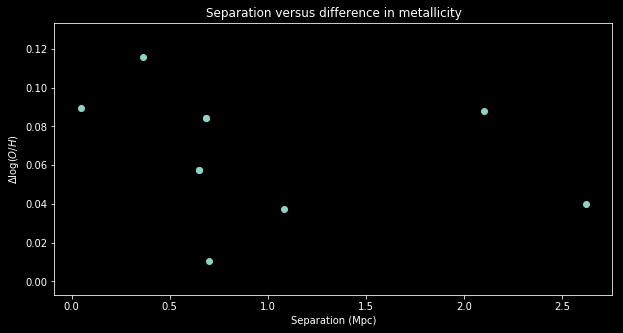

In [91]:
plt.figure(figsize=(10,5))
plt.scatter(ddList[0],ddList[1])
plt.title('Separation versus difference in metallicity')
plt.xlabel('Separation (Mpc)')
plt.ylabel(r'$\Delta\log(O/H)$')

I mean there's only 8 objects here, so we definitely cannot make any conculsions.

## Just some extra notes

I think it's worth my time later to make another clean version or something. Play with `astroquery` to see if there's an easier way to get these spectra automatically.

[try this](https://astroquery.readthedocs.io/en/latest/api/astroquery.sdss.SDSSClass.html#astroquery.sdss.SDSSClass.query_region)

holy butts `astroquery` has an SQL SEARCH?! https://astroquery.readthedocs.io/en/latest/api/astroquery.sdss.SDSSClass.html#astroquery.sdss.SDSSClass.query_sql

yeah maybe i should make a new clean one later.

In [92]:
intObjs[10]

(35.901, 0.226)

In [93]:
co = coords.SkyCoord(intObjs[10][0],intObjs[10][1],unit='deg')

In [94]:
result = SDSS.query_region(co,radius=10*u.arcsec,spectro=True)
result = table.unique(result,keys='objid',keep='last')
result

ra,dec,objid,run,rerun,camcol,field,z,plate,mjd,fiberID,specobjid,run2d,instrument
float64,float64,int64,int64,int64,int64,int64,float64,int64,int64,int64,int64,int64,bytes4
35.90080789547,0.2256778635829,1237666408458158160,4874,301,4,661,0.02494591,406,51876,494,457251183338219520,26,SDSS
35.8998455320128,0.223802006139141,1237666408458158161,4874,301,4,661,0.02516786,1508,52944,497,1697993723230578688,26,SDSS
35.9024281256563,0.225438110308396,1237666408458158163,4874,301,4,661,0.02490221,704,52205,496,792769910852839424,26,SDSS
